## Understanding the Neural Network
A neural network consists of:

* `Layers`: Each layer has weights, biases, and an activation function.
* `Forward Propagation`: Computes the output by passing input through the layers.
* `Loss Function`: Measures the error between predicted and true outputs (e.g., cross-entropy for classification, MSE for regression).
* `Backpropagation`: Computes gradients of the loss with respect to weights and biases.
* `Gradient Descent`: Updates weights and biases to minimize the loss.

We’ll implement a fully connected (dense) neural network with customizable layers and activation functions.

---
## Implementing the Code
File 1: `layers.py`
This file defines a Layer class to represent a single layer in the network.

### Explanation:

The Layer class initializes weights and biases randomly.
* `forward`: Computes the output of the layer (linear transformation + activation).
* `backward`: Computes gradients and updates weights/biases using the chain rule.

In [ ]:
import numpy as np

class Layer:
    def __init__(self, input_size, output_size, activation=None):
        # Initialize weights and biases with small random values
        self.weights = np.random.randn(input_size, output_size) * 0.01
        self.biases = np.zeros((1, output_size))
        self.activation = activation  # Activation function (e.g., 'relu', 'sigmoid', 'softmax')
        # Store intermediate values for backpropagation
        self.input = None
        self.z = None  # Pre-activation output
        self.a = None  # Post-activation output

    def forward(self, X):
        # Forward pass: X is the input (batch_size, input_size)
        self.input = X
        self.z = np.dot(X, self.weights) + self.biases  # Linear transformation
        if self.activation == 'relu':
            self.a = relu(self.z)
        elif self.activation == 'sigmoid':
            self.a = sigmoid(self.z)
        elif self.activation == 'softmax':
            self.a = softmax(self.z)
        else:
            self.a = self.z  # No activation
        return self.a

    def backward(self, delta, learning_rate):
        # Backward pass: delta is the gradient from the next layer
        if self.activation == 'relu':
            delta = delta * relu_derivative(self.z)
        elif self.activation == 'sigmoid':
            delta = delta * sigmoid_derivative(self.z)
        elif self.activation == 'softmax':
            # Softmax derivative is handled in the loss function (cross-entropy)
            pass

        # Compute gradients
        dW = np.dot(self.input.T, delta)  # Gradient w.r.t weights
        db = np.sum(delta, axis=0, keepdims=True)  # Gradient w.r.t biases
        dX = np.dot(delta, self.weights.T)  # Gradient w.r.t input (for previous layer)

        # Update weights and biases
        self.weights -= learning_rate * dW
        self.biases -= learning_rate * db
        return dX

In [21]:
import numpy as np
weights = np.random.randn(5, 3) // 2
bias = np.ones((1, 3))
X = np.random.randn(10, 5) // 2 # (batch_size, input_size)
z = np.dot(X, weights) + bias # Linear transformation
print(f"weights: {weights}")
print(weights.shape)
print(f"\nbias: {bias}")
print(bias.shape)
print(f"\nX: {X}")
print(X.shape)
print(f"\nz: {z}")
print(z.shape)

weights: [[ 0. -1. -1.]
 [-1.  0.  0.]
 [-1. -1.  0.]
 [-1. -1.  0.]
 [-1.  0. -1.]]
(5, 3)

bias: [[1. 1. 1.]]
(1, 3)

X: [[ 0.  0. -1. -1.  1.]
 [-1.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0. -1. -1.  0.]
 [ 0.  0. -1.  0. -2.]
 [ 0.  0.  0.  0.  0.]
 [-1.  0. -1. -1.  0.]
 [ 0. -1. -1. -1. -1.]
 [ 0. -2.  0.  0.  0.]
 [-1.  0. -1.  0. -1.]]
(10, 5)

z: [[2. 3. 0.]
 [2. 3. 2.]
 [1. 1. 1.]
 [3. 3. 1.]
 [4. 2. 3.]
 [1. 1. 1.]
 [3. 4. 2.]
 [5. 3. 2.]
 [3. 1. 1.]
 [3. 3. 3.]]
(10, 3)


In [24]:
def relu_derivative(z):
    return np.where(z > 0, 1, 0)

delta = np.array([1, 2, 3])
z = np.array([-1, 0, 1])
delta = delta * relu_derivative(z)
print(relu_derivative(z))
print(delta)

db = np.sum(delta, axis=0, keepdims=True)
print(db)

[0 0 1]
[0 0 3]
[3]


In [7]:
import numpy as np
x = np.array([[1, 2, 3]])
x - np.max(x, axis=1, keepdims=True)

array([[-2, -1,  0]])

File 2: `activations.py`

Move the activation functions and their derivatives into a separate file for reusability.

In [1]:
import numpy as np

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Subtract max for stability
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

File 3: `model.py`

This file defines the NeuralNetwork class, which combines layers and implements training logic.
### Explanation:

* `add_layer`: Adds a layer to the network.
* `forward`: Passes input through all layers.
* `compute_loss`: Implements cross-entropy (for classification) and MSE (for regression).
* `backward`: Computes gradients and updates weights.
* `train`: Runs the training loop with forward and backward passes.

### When to use which loss:

* Cross-entropy: Use for classification (e.g., Iris, MNIST) where outputs are probabilities.
* MSE: Use for regression where outputs are continuous values.

In [2]:
import numpy as np
from layers import Layer

class NeuralNetwork:
    def __init__(self):
        self.layers = []

    def add_layer(self, layer):
        self.layers.append(layer)

    def forward(self, X):
        # Forward propagation through all layers
        output = X
        for layer in self.layers:
            output = layer.forward(output)
        return output

    def compute_loss(self, y_pred, y_true, loss_type='cross_entropy'):
        # Compute loss
        m = y_true.shape[0]  # Number of samples
        if loss_type == 'cross_entropy':
            # Add small epsilon to avoid log(0)
            loss = -np.sum(y_true * np.log(y_pred + 1e-15)) / m
        elif loss_type == 'mse':
            loss = np.mean((y_pred - y_true) ** 2)
        return loss

    def backward(self, y_pred, y_true, learning_rate, loss_type='cross_entropy'):
        # Backward propagation
        if loss_type == 'cross_entropy':
            # For softmax + cross-entropy, gradient is (y_pred - y_true)
            delta = y_pred - y_true
        elif loss_type == 'mse':
            delta = 2 * (y_pred - y_true)  # Derivative of MSE

        # Propagate gradient backward through layers
        for layer in reversed(self.layers):
            delta = layer.backward(delta, learning_rate)

    def train(self, X, y, epochs, learning_rate, loss_type='cross_entropy', verbose=True):
        losses = []
        for epoch in range(epochs):
            # Forward pass
            y_pred = self.forward(X)
            # Compute loss
            loss = self.compute_loss(y_pred, y_true=y, loss_type=loss_type)
            losses.append(loss)
            # Backward pass
            self.backward(y_pred, y, learning_rate, loss_type)
            if verbose and epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")
        return losses

    def predict(self, X):
        # Return class predictions (argmax for classification)
        y_pred = self.forward(X)
        return np.argmax(y_pred, axis=1)

In [37]:
import pandas as pd
import numpy as np

data = np.random.randint(0, 10, (10, 5))
df = pd.DataFrame(data, columns=['A', 'B', 'C', 'D', 'E'])

target_column = 'E'

X = df.drop(target_column, axis=1).values
y = df[target_column].values

y_unique = np.unique(y)

y_one_hot = np.zeros((y.shape[0], len(y_unique)))
for i, label in enumerate(y_unique):
    y_one_hot[y == label, i] = 1
y = y_one_hot
y = np.argmax(y, axis=1)
y_new = np.random.randn(y.shape[0])*10 // 6
y_new = np.array([int(i) for i in y_new])

np.sum(y_new == y)

1

File 4: `utils.py`

This file handles data loading, preprocessing, evaluation, and visualization.
### Explanation:

* `load_data`: Loads a CSV and optionally one-hot encodes the labels.
* `preprocess_data`: Normalizes features and splits data.
* `accuracy`, `confusion_matrix`, `precision_recall`: Evaluation metrics.
* `save_model`, `load_model`: Save/load weights using NumPy.
* `plot_metrics`: Visualizes training loss (optional).

In [46]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def load_data(file_path, target_column, one_hot=True):
    # Load CSV with Pandas
    data = pd.read_csv(file_path)
    X = data.drop(columns=[target_column]).values  # Features
    y = data[target_column].values  # Labels

    # One-hot encode labels if classification
    if one_hot:
        y_unique = np.unique(y)
        y_one_hot = np.zeros((y.shape[0], len(y_unique)))
        for i, label in enumerate(y):
            y_one_hot[i, label] = 1
        y = y_one_hot
    return X, y

def preprocess_data(X, y, test_size=0.2):
    # Normalize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    # Split into train/test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

def accuracy(y_pred, y_true):
    # Accuracy for classification
    y_true_labels = np.argmax(y_true, axis=1)
    return np.mean(y_pred == y_true_labels)

def confusion_matrix(y_pred, y_true):
    # Simple confusion matrix
    y_true_labels = np.argmax(y_true, axis=1)
    num_classes = y_true.shape[1]
    cm = np.zeros((num_classes, num_classes))
    for t, p in zip(y_true_labels, y_pred):
        cm[t, p] += 1
    return cm

def precision_recall(y_pred, y_true):
    # Precision and recall per class
    cm = confusion_matrix(y_pred, y_true)
    precision = np.diag(cm) / np.sum(cm, axis=0)
    recall = np.diag(cm) / np.sum(cm, axis=1)
    return precision, recall

def save_model(model, filename):
    # Save weights and biases using NumPy
    params = [{'weights': layer.weights, 'biases': layer.biases} for layer in model.layers]
    np.save(filename, params)

def load_model(filename):
    # Load weights and biases
    params = np.load(filename, allow_pickle=True)
    nn = NeuralNetwork()
    for param in params:
        layer = Layer(param['weights'].shape[0], param['weights'].shape[1])
        layer.weights = param['weights']
        layer.biases = param['biases']
        nn.add_layer(layer)
    return nn

def plot_metrics(losses, title="Training Loss"):
    plt.plot(losses)
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

In [3]:
from model import NeuralNetwork
from layers import Layer
from utils import load_data, preprocess_data, accuracy, confusion_matrix, precision_recall, save_model, plot_metrics, load_model

X, y = load_data('iris.csv', target_column='species', one_hot=True)
X_train, X_test, y_train, y_test = preprocess_data(X, y)

In [5]:
y_train.shape

(120, 3)

In [6]:
nn.add_layer(Layer(input_size=X.shape[1], output_size=10, activation='relu'))
nn.add_layer(Layer(input_size=10, output_size=y_train.shape[1], activation='softmax'))

In [7]:
history = nn.train(X_train, y_train, epochs=1000, learning_rate=0.001, loss_type='cross_entropy')

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 8418.43it/s]

Epoch: 1
Loss:  1.7632
Epoch: 2
Loss:  1.0424
Epoch: 3
Loss:  0.8220
Epoch: 4
Loss:  0.7342
Epoch: 5
Loss:  0.6788
Epoch: 6
Loss:  0.6386
Epoch: 7
Loss:  0.6078
Epoch: 8
Loss:  0.5832
Epoch: 9
Loss:  0.5631
Epoch: 10
Loss:  0.5471
Epoch: 11
Loss:  0.5337
Epoch: 12
Loss:  0.5218
Epoch: 13
Loss:  0.5111
Epoch: 14
Loss:  0.5016
Epoch: 15
Loss:  0.4929
Epoch: 16
Loss:  0.4853
Epoch: 17
Loss:  0.4781
Epoch: 18
Loss:  0.4715
Epoch: 19
Loss:  0.4651
Epoch: 20
Loss:  0.4588
Epoch: 21
Loss:  0.4529
Epoch: 22
Loss:  0.4472
Epoch: 23
Loss:  0.4417
Epoch: 24
Loss:  0.4363
Epoch: 25
Loss:  0.4312
Epoch: 26
Loss:  0.4262
Epoch: 27
Loss:  0.4212
Epoch: 28
Loss:  0.4165
Epoch: 29
Loss:  0.4116
Epoch: 30
Loss:  0.4064
Epoch: 31
Loss:  0.4015
Epoch: 32
Loss:  0.3969
Epoch: 33
Loss:  0.3925
Epoch: 34
Loss:  0.3884
Epoch: 35
Loss:  0.3844
Epoch: 36
Loss:  0.3803
Epoch: 37
Loss:  0.3761
Epoch: 38
Loss:  0.3720
Epoch: 39
Loss:  0.3681
Epoch: 40
Loss:  0.3643
Epoch: 41
Loss:  0.3607
Epoch: 42
Loss:  0.3571
E

In [8]:
y_pred = nn.predict(X_test)
acc = accuracy(y_pred, y_test)
cm = confusion_matrix(y_pred, y_test)
precision, recall = precision_recall(y_pred, y_test)

In [9]:
print(f"Accuracy: {acc:.4f}")
print("Confusion Matrix:\n", cm)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 100.0000
Confusion Matrix:
 [[10.  0.  0.]
 [ 0.  9.  0.]
 [ 0.  0. 11.]]
Precision: [1. 1. 1.]
Recall: [1. 1. 1.]


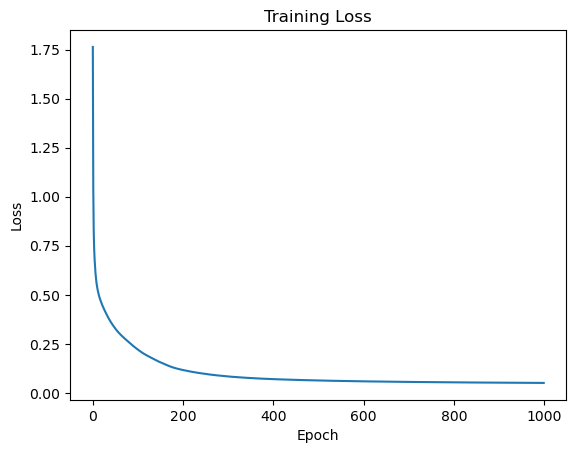

In [10]:
plot_metrics(history)

In [25]:
import numpy as np
import pandas as pd
df = pd.read_csv('iris.csv')
outputs = df['species']
unique_outputs = outputs.unique()
test_sample = np.array([[6.3,2.7,4.9,1.8]])
# unique_outputs[nn.predict(test_sample)]
nn.predict(test_sample)

array([2])

In [9]:
save_model(nn, 'model_weights.npy')

In [2]:
loaded_nn = load_model('model_weights.npy')
y_pred_loaded = loaded_nn.predict(X_test)
print(f"Accuracy with loaded model: {accuracy(y_pred_loaded, y_test):.4f}")

Accuracy with loaded model: 70.0000
